# Deep Learning - Programing Assignment 3
# Convolutional Neural Networks
By Shu-Nong Wu | RIN: 661371234 | RCS: wus7
## 1. Introduction
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
In programming assignement 1 and 2 the task was to classify the MNIST dataset which is a dataset comprised of 10 classes of handwritten numbers labeled 0 to 9. In both logistic regression and neural networks there was one fatal mistake that was made that limited their abilities to classify images. This mistake was the fact that each image which was a 28x28 pixel image and flattened it into 784 long vector. This destroy a lot of valuable information because the edges and shapes of the image are getting rearranged. This problem gets addressed in **convolutional neural networks**.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The architure of a convolutional neural network generally consists of and input layer $X$ that is the same shape as the input images, convolutional layers $C$, activation layers $A$, pooling layers $P$, fully connected layers $\vec{P}$, and an output layer. The architecture is shown below.

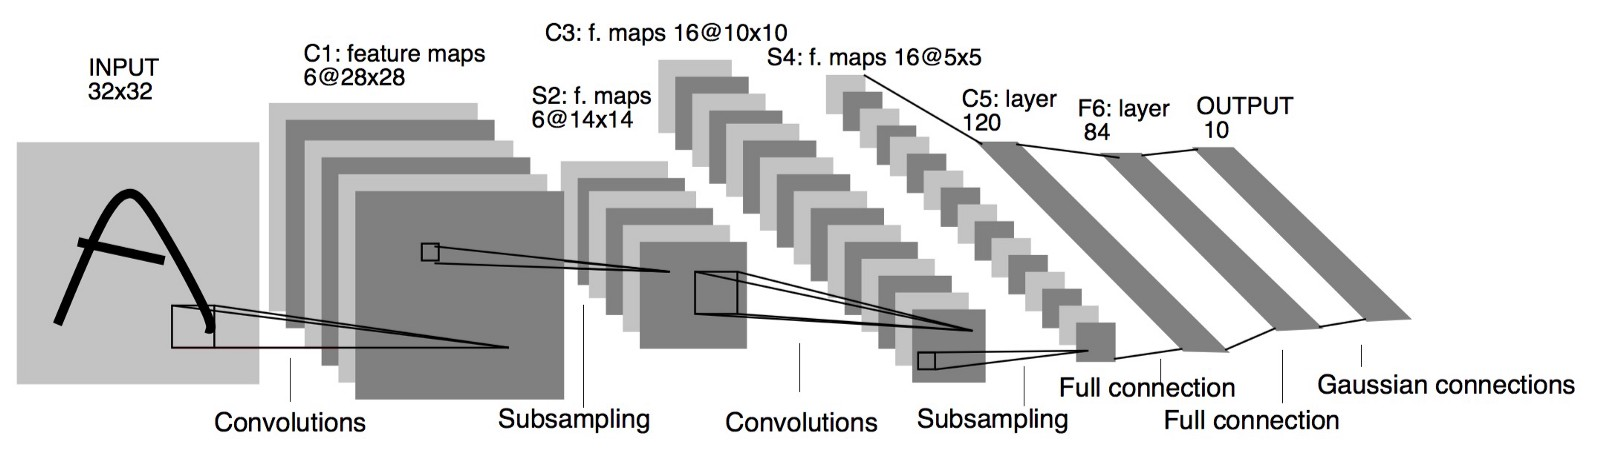

In [1]:
from IPython.display import Image
Image(filename='report/architecture.jpg') 

<center>source:https://towardsdatascience.com/neural-network-architectures-156e5bad51</center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The most important component of the convolutional neural network is the convolutional layer $C$. A convolutional layer is created by taking a **filter** (size $KxKxD$ where $K$ is the filter size and $D$ is the number of channels in the previous layer) and **convolving** it over the previous layer. Convolution between the filter and previous layer is done by taking the filter, placing it on top of the image, element wise multipliying the filter with a chunk of the image producing element in the convolutional layer, sliding the filter to the next part of the image, and repeating this process for every chunk of the image. In the end, every element of the convolutional layer ought to be connected with an area of the previous layer as shown in the figure above. Between these connections are a set of weights which are the filter values. Because several filters are used for each convolutional layer, there will be the same number of channels of the convolutional layer as there are filters. Finally a biases will be added to each channel of the convolutional layer. The activation layer $A$ simply takes the convolutional layer and passes it through an **activation function**. The pooling layer $P$ **downsamples** the activation layer by combining adjacent clusters of pixels to generate a smaller resolution image. When combining pixels the output pixel can either be average of the pixels (average pooling) or max of the pixels (max pooling). Next the pooling layer is **flattened** to create a fully connected layer $\vec{P}$. Finally a conventional neural network is added to the end of the network and follows simular architecture and equations as the neural network in programing assignment 2.

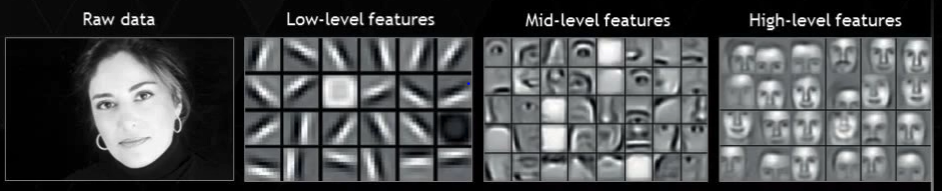

In [2]:
Image(filename='report/features.png') 

<center>source:https://medium.com/machine-learning-for-humans/neural-networks-deep-learning-cdad8aeae49b</center>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The image above provides an intuitive understanding of what convolutional neural networks are doing. Given an input image filters are convolved over these images. Each filter is going to be sensitive to certain types of features such as horizontal, vertical, diagonal lines, curves, etc. The next layer will be sensitive to combinations of features from the previous layer such as crosses, T's, parallel lines, circles. As you go deeper and deeper in the network, the filters of the convolutional layer become sensitive to more and more abstract shapes. Finally these highly abstract shapes gets passes through a deep neural network. At this point features get passed through a deep neural network for classification. This process is explained in programming assignment 2.

#### Import Dependencies

In [3]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import logging; logging.basicConfig(level=logging.DEBUG, filename='pa3.log')
import pickle
import time
from datetime import datetime
from pa3_utils import * # Load constants, helper classes, and helper functions
# tf.set_random_seed(0)
# np.random.seed(0)

C:\Users\wus7\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Load and Preprocess Data
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
For this project the input image must be **preprocesses**. This is done by taking the input image and dividing the pixel intensities by 255. The images are then **zero centered** by taking each sample and subtracting the average of each channel over all samples. This is the VGG16 implementation of zero centering but CNN_S implements zero centering by subtracting each image by the average for each pixel in a channel. <BR>
Source: https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c

In [4]:
# Load raw un-preprocessed data
with open('cifar_10_tf_train_test.pkl', 'rb') as cifar:
    train_img, train_labels, test_img, test_labels = pickle.load(cifar, encoding='latin1')

# Convert images to float, scale the images from 0-1, 
# normalize each color channel over all sample - VGG16 implementation
train_img = train_img.astype(np.float32)
test_img = test_img.astype(np.float32)
train_img = train_img/255.
test_img = test_img/255.
train_img_avg = np.average(train_img.astype(np.float64), axis=(0,1,2))
train_img = train_img-train_img_avg
test_img_avg = np.average(test_img.astype(np.float64), axis=(0,1,2))
test_img = test_img-test_img_avg

# Put data into Data class
train_data = Data(train_img, np.array(train_labels))
test_data = Data(test_img, np.array(test_labels))

## 2. Theory
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
To implement a neural network one needs to define hyper parameters, initialize weights and biases, define the neural network architecture (filter size, filter numbers, strides, max or average pooling), define optimizer, and perform training.
### 2.1. Hyper Parameters
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The same hyper parameters as last time are being used.

In [5]:
LEARNING_RATE = .001
LAMBDA = .001
NUM_EPOCHS = 50
BATCH_SIZE = 128

### 2.2. Model Parameters
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The model parameters define the shape of the filters and number of filters for each convolutional layer. Then the kernal size and stride is defined for the pooling layer. Finally the number of fully connected connection are defined. These parameter will be explained in more detail in the later section of this report.

In [6]:
L1_FILT_H, L1_FILT_W = 5, 5
L2_FILT_H, L2_FILT_W = 5, 5
L3_FILT_H, L3_FILT_W = 3, 3
L1_FILT_NUM = 32
L2_FILT_NUM = 32
L3_FILT_NUM = 64
P1_K = 2
P2_K = 2
P1_STRIDE = 2
P2_STRIDE = 2
FC_CONNECTIONS = 3*3*L3_FILT_NUM

### 2.3. Initialize Weights and Biases
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The filter (convolutional layer weights) and fully connected weights are initialized using **Xavier Initialization**. Xavier Initialization is when all the variable are initialized based on an gaussian distribution with a standard deviation $\sigma = \sqrt{2}\sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$. For instances where $n_{inputs}\approx n_{outputs}$ then $\sigma=\frac{1}{n_{inputs}}$

In [7]:
tf.reset_default_graph()

# Tensorflow offers a lot of built in initalizers that can be used
xavier_init = tf.contrib.layers.xavier_initializer()
zero_init = tf.zeros_initializer()

# Define weights for conv layer 1 to 3 and fc layer
with tf.name_scope('weights') as scope:
    W_c_1 = tf.get_variable(shape=[L1_FILT_H, L1_FILT_W, channels, L1_FILT_NUM],
                            dtype=tf.float32,
                            initializer=xavier_init,
                            name='conv_l1_weights')
    W_c_2 = tf.get_variable(shape=[L2_FILT_H, L2_FILT_W, L1_FILT_NUM, L2_FILT_NUM],
                            dtype=tf.float32,
                            initializer=xavier_init,
                            name='conv_l2_weights')
    W_c_3 = tf.get_variable(shape=[L3_FILT_H, L3_FILT_W, L2_FILT_NUM, L3_FILT_NUM],
                            dtype=tf.float32,
                            initializer=xavier_init,
                            name='conv_l3_weights')
    W_fc = tf.get_variable(shape=[FC_CONNECTIONS, NUM_CLASSES],
                           dtype=tf.float32,
                           initializer=xavier_init,
                           name='fc_weights')
# Define biases for conv layer 1 to 3 and fc layer
with tf.name_scope('biases') as scope:
    B_c_1 = tf.get_variable(shape=[L1_FILT_NUM],
                            dtype=tf.float32,
                            initializer=zero_init,
                            name='conv_l1_biases') + .1
    B_c_2 = tf.get_variable(shape=[L2_FILT_NUM],
                            dtype=tf.float32,
                            initializer=zero_init,
                            name='conv_l2_biases') + .1
    B_c_3 = tf.get_variable(shape=[L3_FILT_NUM],
                            dtype=tf.float32,
                            initializer=zero_init,
                            name='conv_l3_biases') + .1
    B_fc = tf.get_variable(shape=[NUM_CLASSES],
                           dtype=tf.float32,
                           initializer=zero_init,
                           name='fc_biases') + .1

### 2.4. Size of Each Set of Weights and Biases

In [8]:
print('Shape of W_c_1 is {}x{}x{}x{}'.format(L1_FILT_H,L1_FILT_W,channels,L1_FILT_NUM))
print('Number of elements in W_c_1 = {}'.format(L1_FILT_H * L1_FILT_W * channels * L1_FILT_NUM))
print('Shape of W_c_2 is {}x{}x{}x{}'.format(L2_FILT_H,L2_FILT_W,L1_FILT_NUM,L2_FILT_NUM))
print('Number of elements in W_c_2 = {}'.format(L2_FILT_H * L2_FILT_W * L1_FILT_NUM * L2_FILT_NUM))
print('Shape of W_c_3 is {}x{}x{}x{}'.format(L3_FILT_H,L3_FILT_W,L2_FILT_NUM,L3_FILT_NUM))
print('Number of elements in W_c_3 = {}'.format(L3_FILT_H * L3_FILT_W * L2_FILT_NUM * L3_FILT_NUM))
print('Shape of W_fc is {}x{}'.format(FC_CONNECTIONS,NUM_CLASSES))
print('Number of elements in W_fc = {}'.format(FC_CONNECTIONS * NUM_CLASSES))
print('Shape of B_c_1 is {}'.format(L1_FILT_NUM))
print('Number of elements in B_c_1 = {}'.format(L1_FILT_NUM))
print('Shape of B_c_2 is {}'.format(L2_FILT_NUM))
print('Number of elements in B_c_2 = {}'.format(L2_FILT_NUM))
print('Shape of B_c_3 is {}'.format(L3_FILT_NUM))
print('Number of elements in B_c_3 = {}'.format(L3_FILT_NUM))
print('Shape of B_fc is {}'.format(NUM_CLASSES))
print('Number of elements in B_fc = {}'.format(NUM_CLASSES))

Shape of W_c_1 is 5x5x3x32
Number of elements in W_c_1 = 2400
Shape of W_c_2 is 5x5x32x32
Number of elements in W_c_2 = 25600
Shape of W_c_3 is 3x3x32x64
Number of elements in W_c_3 = 18432
Shape of W_fc is 576x10
Number of elements in W_fc = 5760
Shape of B_c_1 is 32
Number of elements in B_c_1 = 32
Shape of B_c_2 is 32
Number of elements in B_c_2 = 32
Shape of B_c_3 is 64
Number of elements in B_c_3 = 64
Shape of B_fc is 10
Number of elements in B_fc = 10


### 2.4. Define Model

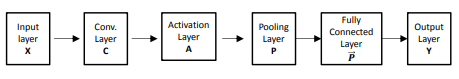

In [9]:
Image(filename='report/model.PNG') 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The convolutional neural network model consists of a input layer, convolutional layers, activation layers, pooling layers, fully connected layers, and a output layer.
#### 2.4.1 . Convolutional Layer + Activation Layer
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
For the convolutional layer, a filter is convolved over the previous layer. As described in the introduction section, this process is do by elementwise multiplying the filter weights with the layer weights to product one value in the convolution layer. The filter is then shifted over by a certain pixel distance. How far of a distance this pixel skips is known as the strides. In this case the convolutional strides is just 1. Then the biases is added to each layer The equation below show a mathematical representation of convolution where $C(r,c)$ is the convolutional layer value at pixel $r$ (row) and $c$ (column), $I$ is the input layer, $K$ is the filter size, $D$ is the number of input channels, $W_x$ is the filter weights, and $W_{xo}$ is the filter biases.
$$
\begin{split}
C(r,c)&=I*W_x(r,c)+W_{xo}(r,c) \\
&=\sum^D_{l=1}\sum^K_{i=1}\sum^K_{j=1}I(r+i-1,c+j-1,l)W_x(i,j,l)+W_{xo}(r,c)
\end{split}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Next comes the activation layer which is produced by applying an activation function to the convolutional layer. In this case the activation funtion is ReLU
$$
A=ReLU(C)=max(0,C)
$$

In [10]:
def convolutional_layer(input_layer, weights, biases, name):
    with tf.name_scope('conv_layer') as scope:
        conv_layer = tf.nn.conv2d(input_layer, weights, strides=[1,1,1,1], padding='VALID')
        conv_layer = tf.add(conv_layer,biases, name='{}_prerelu'.format(name))
        conv_layer = tf.nn.relu(conv_layer, name=name)
        tf.summary.histogram('weights',weights)
        tf.summary.histogram('biases',biases)
        tf.summary.histogram('activation',conv_layer)
        return conv_layer

#### 2.4.2. Pooling Layer
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The pooling layer is created by downsampling the activation layer. This is done by taking a kernel of a certain size and convolving over the activation layer with a certain stride. This procedure is simular to the one the convolutional layer. However, this time rather that taking the input activation layer and multiplying it with weights, the average or maximum values within that kernel is choses to be used in the pooling layer. In this case the kernel size is 2x2, the stride is 2, and max pooling is used so the max value within that kernel is being chosen. The resulting layer is smaller than the input layer. This has the advantage of reducing the dimentionality and complexity of the network thus conserving computational resources and mitigating overfitting. In addition pooling also allows the neural network to be invariant to translation as large translations in the activation layer wont appear as large in the pooling layer. The equation for pooling is seen below where $P$ is the pooling layer $A$ is the activation layer, $r,c,and\ d$ are row, column, and channel.
$$
\begin{split}
P[r][c]&=max\ A[r(r-1)xd+i][(c-1)xd+j] \\
&for\ 1\leq i\leq d\ and\ 1\leq j\leq d
\end{split}
$$

In [15]:
def pooling_layer(input_layer, k, strides, name):
    with tf.name_scope('pool_layer') as scope:
        pool_layer = tf.nn.max_pool(input_layer,
                                    ksize=[1,k,k,1], 
                                    padding='VALID',
                                    strides=[1,strides,strides,1],
                                    name=name)
        tf.summary.histogram('pooling',pool_layer)
        return pool_layer

#### 2.4.3. Fully Connected Layer
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The fully connected layer is simply the result of taking the pooling layer and flattening it. It doesn't matter how one flattens it so long as is unflattened in opposite was as it was flattened durring backpropagation.

In [17]:
def fc_layer(input_layer, name):
    with tf.name_scope('fc_layer') as scope:
        full_con_layer = tf.reshape(input_layer, shape=[-1, FC_CONNECTIONS], name=name)
        tf.summary.histogram('fully_connected',full_con_layer)
        return full_con_layer

#### 2.4.4. Output Layer
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The output layer is the same output layer from the deep neural network programming assignment
$$
\hat{Y}=\sigma(W_o^t \vec{P}+W_{o\ 0})
$$

In [18]:
def output_layer(fc_layer, weights, biases):
    with tf.name_scope('output_layer') as scope:
        logits = tf.add(tf.matmul(fc_layer, weights), biases, name='logits')
        Y_hat = tf.nn.softmax(logits, axis=1, name='Y_hat')
        tf.summary.histogram('weights',weights)
        tf.summary.histogram('biases',biases)
        tf.summary.histogram('logits',logits)
        return logits, Y_hat

#### 2.4.5. Size of Each Layer

In [19]:
with tf.name_scope('input_data') as scope:
    X = tf.placeholder(dtype=tf.float32, shape=[None, height, width, channels], name='images')
    Y = tf.placeholder(dtype=tf.int32, shape=[None], name='labels')
C1 = convolutional_layer(X, W_c_1, B_c_1, 'conv_l1')
P1 = pooling_layer(C1, P1_K, P1_STRIDE, 'pool_l1')
C2 = convolutional_layer(P1, W_c_2, B_c_2, 'conv_l2')
P2 = pooling_layer(C2, P2_K, P2_STRIDE, 'pool_l2')
C3 = convolutional_layer(P2, W_c_3, B_c_3, 'conv_l3')
FC = fc_layer(C3, 'fc_layer')
logits, Y_hat = output_layer(FC, W_fc, B_fc)

print('X Shape: {}'.format(X.shape[1:]))
print('Y Shape: {}'.format(Y.shape[1:])) # not one hot encoded
print('C1 Shape: {}'.format(C1.shape[1:]))
print('P1 Shape: {}'.format(P1.shape[1:]))
print('C2 Shape: {}'.format(C2.shape[1:]))
print('P2 Shape: {}'.format(P2.shape[1:]))
print('C3 Shape: {}'.format(C3.shape[1:]))
print('FC Shape: {}'.format(FC.shape[1:]))
print('Y_hat Shape: {}'.format(Y_hat.shape[1:]))

X Shape: (32, 32, 3)
Y Shape: ()
C1 Shape: (28, 28, 32)
P1 Shape: (14, 14, 32)
C2 Shape: (10, 10, 32)
P2 Shape: (5, 5, 32)
C3 Shape: (3, 3, 64)
FC Shape: (576,)
Y_hat Shape: (10,)


### 2.5. Define Loss Function
Negative log likelyhood loss was used with L2 regularization
$$ L(D, \theta) = -\frac{1}{M} {\sum\limits_{m=1}^{M}\log p(Y[m]|X[m],\theta) = L(D, \theta) = - \frac{1}{M} \sum\limits_{m=1}^{M} \sum\limits_{k^{'}=1}^{K} Y[m][k^{'}] \log\sigma_m(\theta_k^t, X[m])} $$

$$ R(\theta) = \theta^t\theta$$

$$ L(D, \theta) = - \frac{1}{M} \sum\limits_{m=1}^{M} \sum\limits_{k^{'}=1}^{K}l[X[m],Y[m],\theta)+\lambda R(\theta)$$

In [20]:
with tf.name_scope('loss') as scope:
    mse = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y)
    regularizer = sum([tf.nn.l2_loss(weight) for weight in [W_c_1,W_c_2,W_c_3,W_fc]])
    loss = mse + LAMBDA * regularizer
    loss = tf.reduce_mean(loss, name='xent_loss')

### 2.6. Optimizer
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The previous programming assignments the task was to manually compute the gradients, multiply it by a learning rate and assigning it back to the weights and biases. However in this assignment we are allowed to use the inbuilt Tensorflow optimizers. To do backpropagation in Tensorflow one needs to define an **optimizer**. In this case AdamOptimizer is being used. Although the exact AdamOptimizer algorithm won't be explained in this report, it is a combination of AdaGrad (adaptive gradient) and MomentumOptimizer (the learning rate is dependant on the learning rate from previous time steps). One the optimizer is defined we specify a learning rate as well as the value we wish to minimize. In this case we wish to minimize the loss or error of our model. Through antidifferentiation Tensorflow will automatically computer the gradients and apply them to the weights and biases. The equations for computing the gradients is provided below.
#### 2.6.1. Gradients of Weights and Biases (Fully Connected to Output Layer)
$$
\begin{split}
\nabla W^o&=\frac{\partial\hat{Y}}{\partial W^o}\nabla Y \\
&=\sigma(W^{o\ t} \vec{P}+W^o_0)(1-\sigma(W^{o\ t} \vec{P}+W^o_0))\cdot\vec{P}\cdot\nabla Y
\end{split}
$$

$$
\begin{split}
\nabla W^o_0&=\frac{\partial\hat{Y}}{\partial W^o_0}\nabla Y \\
&=\sigma(W^{o\ t} \vec{P}+W^o_0)(1-\sigma(W^{o\ t} \vec{P}+W^o_0))\cdot\nabla Y
\end{split}
$$
#### 2.6.2. Gradient of Fully Connected Layer
$$
\begin{split}
\nabla\vec{P}&=\frac{\partial\hat{Y}}{\partial\vec{P}}\nabla Y \\
&=\sigma(W^{o\ t} \vec{P}+W^o_0)(1-\sigma(W^{o\ t} \vec{P}+W^o_0))\cdot W^o \cdot\nabla Y
\end{split}
$$
#### 2.6.3. Gradient of the Pooling Layer
The gradient of the pooling layer is simply the reshaped version of the fully connected layer. It must be reshaped in the inverse way that it was flattened durring forward propagation.
#### 2.6.4. Gradient of the Activation Layer
$$
for\ r=1\ to\ N^P_r \\
for\ c=1\ to\ N^P_c \\
for\ i=1\ to\ d \\
for\ j=1\ to\ d \\
\nabla A[(r-1)\cdot s+i][(c-1)\cdot s+j]=\bigg\{
\begin{matrix}
\begin{split}
& \nabla P[r][c]\ if\ i=i^*[r]\ and\ j=j^*[c]\\
& 0 \quad\quad\quad else
\end{split}
\end{matrix}\\
where\ i^*[r], j^*[c]=argmax\ A[(r-1)\cdot s+i][(c-1)\cdot s+j]\\
1\leq i \leq d \\
1\leq j \leq d
$$
#### 2.6.5. Gradient of the Convolutional Layer
$$
\begin{split}
\nabla C[r][c]&=\frac{\partial ReLU(C[r][c])}{\partial C[r][c]}\nabla A[r][c]\\
&=\bigg\{
\begin{matrix}
\begin{split}
&\nabla A[r][c]\ if\ C[r][c]>0 \\
& 0\quad\quad\quad else
\end{split}
\end{matrix}
\end{split}
$$
#### 2.6.6. Gradient of the Weights and Biases (Input to Convolutional Layer)
$$
\nabla W^X[i][j][l]=\sum^{N_r^C}_{r=1}\sum^{N_c^C}_{c=1}
X[(r-1)\cdot s+i][(c-1)\cdot s+j]\nabla C[r][c]\\
in\ other\ words\ X*\nabla C,where\ *\ stands\ for\ convolution \\
$$

$$
\nabla W^x_0[r][c] = \nabla C[r][c]
$$

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
with tf.name_scope('train') as scope:
    train = optimizer.minimize(loss)

# 3. Results
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Using the convolutional network architecture provided in the pdf instructions, Xavier Initializatoin, and Adam Optimizer with hyper parameters of: learning rate $\eta$ = .001, regularization term $\lambda$=.001, number of steps = 50000 and batch size = 64 an accuracy of 74 percent was obtained.

In [34]:
# Define however many epochs we should save training/testing loss/accuracy
# and save weights and biases
TB_PERIOD = 10
TRAIN_PERIOD = 10
TEST_PERIOD = 100
SAVE_PERIOD = 5000

# For saving a model
predict_op = tf.argmax(Y_hat, 1)
tf.get_collection('validation_nodes')
tf.add_to_collection('validation_nodes', X)
tf.add_to_collection('validation_nodes', Y)
tf.add_to_collection('validation_nodes', predict_op)
saver = tf.train.Saver()

# Find overall accuracy and per class accuracy
with tf.name_scope('accuracy') as scope:
    num_correct = tf.equal(Y, tf.cast(tf.argmax(Y_hat, 1), tf.int32),name='num_correct')
    accuracy = tf.reduce_mean(tf.cast(num_correct, dtype=tf.float32),name='accuracy')

# Tensorboard
time_now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
tensorboard_logdir = 'tf_log/run-{}'.format(time_now)
print('tensorboard log_dir: {}'.format(tensorboard_logdir))
writer = tf.summary.FileWriter(tensorboard_logdir)
writer.add_graph(tf.get_default_graph())
mse_summary = tf.summary.scalar('mse', mse)
regularizer_summary = tf.summary.scalar('regularizer', regularizer)
loss_summary = tf.summary.scalar('loss', loss)
accuracy_summary = tf.summary.scalar('accuracy', accuracy,)
    
# Record training and testing loss and accuracy
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

tensorboard log_dir: tf_log/run-20180407041511


In [ ]:
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(1,NUM_EPOCHS+1):
        X_batch_train, Y_batch_train = train_data.random_batch(BATCH_SIZE)
        sess.run([train], feed_dict={X: X_batch_train, Y: Y_batch_train})

        if epoch%TB_PERIOD == 0:
            m,r,l,a = sess.run([mse_summary,regularizer_summary,loss_summary,accuracy_summary], 
                               feed_dict={X: X_batch_train, Y: Y_batch_train})
            writer.add_summary(m,epoch)
            writer.add_summary(r,epoch)
            writer.add_summary(l,epoch)
            writer.add_summary(a,epoch)

        # Record training loss/accuracy
        if epoch%TRAIN_PERIOD == 0:
            train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch_train, Y: Y_batch_train})
            train_loss_hist.append(train_loss)
            train_acc_hist.append(train_acc)

        # Record testing loss/accuracy
        if epoch%TEST_PERIOD == 0 or epoch == 1:
            X_batch_test, Y_batch_test = test_data.full_batch()
            test_loss, test_acc = sess.run([loss, accuracy], feed_dict={X: X_batch_test, Y: Y_batch_test})
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
            s = sess.run(accuracy_summary, feed_dict={X: X_batch_test, Y: Y_batch_test})
            writer.add_summary(s,epoch)
            print('Epoch: {:<10} | Loss: {:<25} | Test Accuracy {:<20}'.format(epoch, test_loss, test_acc))

        # Record accuracy per digit at the end
        if epoch%NUM_EPOCHS == 0:
            Y_hat_test, Y_batch_test_onehot = sess.run([Y_hat, tf.one_hot(Y,depth=NUM_CLASSES)], 
                                                       feed_dict={X: X_batch_test, Y: Y_batch_test})
            Y_sum_class = np.sum(Y_batch_test_onehot, axis=0).astype(float)
            Y_correct_class = np.max(Y_hat_test, axis=1)
            Y_correct_class = np.equal(np.expand_dims(Y_correct_class, 1), Y_hat_test)
            Y_correct_class = np.logical_and(Y_correct_class, Y_batch_test_onehot).astype(float)
            Y_correct_class = np.sum(Y_correct_class, axis=0)
            test_accuracy_per_class = np.divide(Y_correct_class, Y_sum_class)

        # Save model
        if epoch%SAVE_PERIOD == 0:
            saver_filename = 'models/a{:.3f}_e{}'.format(test_acc_hist[-1]*100, epoch)
            saver.save(sess, saver_filename)

time_elapse = time.time()-start_time
print('{:.3f} sec, {} iterations, {:.3f} iterations/sec'.format(time_elapse, NUM_EPOCHS, NUM_EPOCHS/time_elapse))

### 3.1. Plot Accuracy Over Epochs


<IPython.core.display.Javascript object>


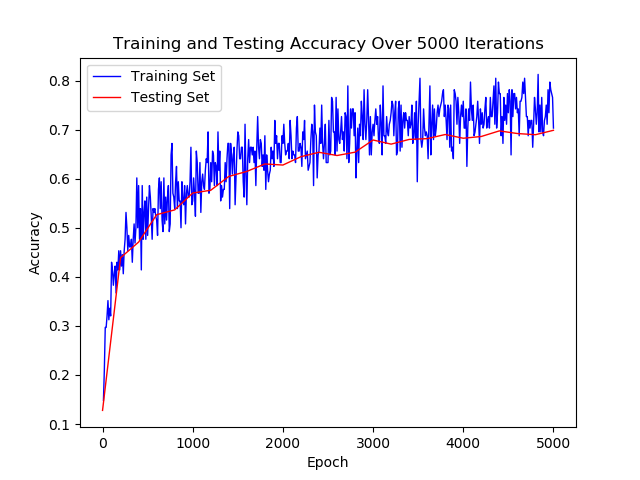

In [15]:
plt.figure()
plt.plot(np.linspace(TRAIN_PERIOD, NUM_EPOCHS, int(NUM_EPOCHS/TRAIN_PERIOD)),
         train_acc_hist, 'b-', linewidth = 1.0)
plt.plot(np.linspace(0, NUM_EPOCHS, int((NUM_EPOCHS+TEST_PERIOD)/TEST_PERIOD)),
         test_acc_hist,'r-', linewidth = 1.0)
plt.title('Training and Testing Accuracy Over {} Iterations'.format(NUM_EPOCHS))
plt.legend(['Training Set', 'Testing Set'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### 3.2. Plot Loss Over Epochs

<IPython.core.display.Javascript object>


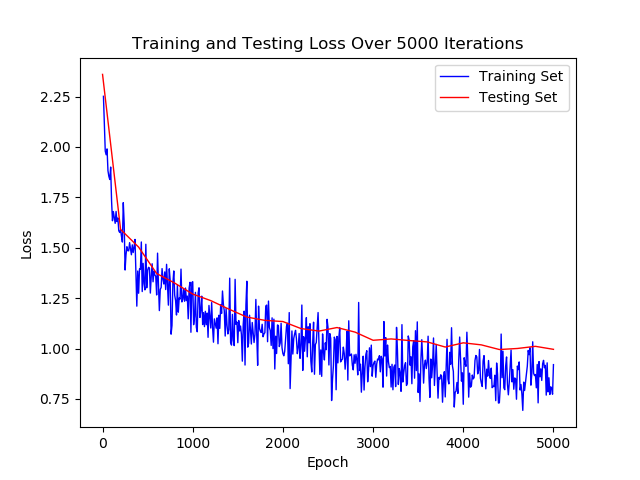

In [16]:
plt.figure()
plt.plot(np.linspace(TRAIN_PERIOD, NUM_EPOCHS, int(NUM_EPOCHS/TRAIN_PERIOD)),
         train_loss_hist, 'b-', linewidth = 1.0)
plt.plot(np.linspace(0, NUM_EPOCHS, int((NUM_EPOCHS+TEST_PERIOD)/TEST_PERIOD)),
         test_loss_hist,'r-', linewidth = 1.0)
plt.title('Training and Testing Loss Over {} Iterations'.format(NUM_EPOCHS))
plt.legend(['Training Set', 'Testing Set'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### 3.3. Final Accuracy by Class

In [17]:
img_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for class_num, accuracy in enumerate(test_accuracy_per_class):
    print('{} classification accuracy = {:.3f}%'.format(img_classes[class_num], accuracy*100.))

airplane classification accuracy = 76.844%
automobile classification accuracy = 78.020%
bird classification accuracy = 61.328%
cat classification accuracy = 51.308%
deer classification accuracy = 56.805%
dog classification accuracy = 60.656%
frog classification accuracy = 80.448%
horse classification accuracy = 74.747%
ship classification accuracy = 81.349%
truck classification accuracy = 77.193%


### 3.4. Visualize Activation Layer

INFO:tensorflow:Restoring parameters from models/a69.860_e5000


<IPython.core.display.Javascript object>


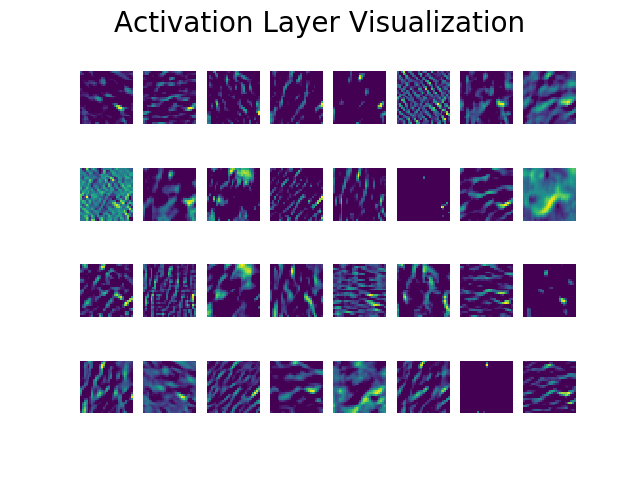

In [18]:
tf.reset_default_graph()
loader = tf.train.import_meta_graph('{}.meta'.format(saver_filename))
with tf.Session() as sess:
    def T(layer):
        '''Helper for getting layer output tensor'''
        return tf.get_default_graph().get_tensor_by_name("{}:0".format(layer))
    
    # Load old model
    sess.run(tf.global_variables_initializer())
    loader.restore(sess,saver_filename)
    
    # Restore desired tensors
    activation_layer = T('conv_l1')
    X = T('images')
    Y = T('labels')
    
    # Get activation layer values and plot them
    X_batch, Y_batch = train_data.random_batch(1)
    act_layers_value = sess.run(activation_layer, feed_dict={X:X_batch, Y:Y_batch})
    fig=plt.figure()
    for layer in range(L1_FILT_NUM):
        fig.add_subplot(4,8,layer+1)
        act_layer_value = np.squeeze(act_layers_value[:,:,:,layer])
        plt.imshow(act_layer_value)
        plt.axis('off')
    fig.suptitle('Activation Layer Visualization', fontsize=20)
    plt.show()

### 3.5. Naive Feature Visualization

INFO:tensorflow:Restoring parameters from models/a69.860_e5000


<IPython.core.display.Javascript object>


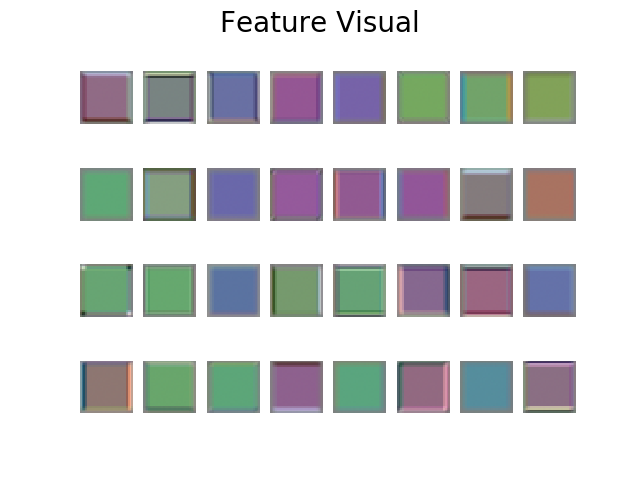

In [19]:
tf.reset_default_graph()
loader = tf.train.import_meta_graph('{}.meta'.format(saver_filename))
with tf.Session() as sess:
    # Load old model
    sess.run(tf.global_variables_initializer())
    loader.restore(sess,saver_filename)

    # start with a gray image with a little noise
    img_noise = np.random.uniform(size=(1,32,32,3)) + 100.0
    
    # Define helper functions
    def visstd(a, s=0.1):
        '''Normalize the image range for visualization'''
        return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

    def T(layer):
        '''Helper for getting layer output tensor'''
        return tf.get_default_graph().get_tensor_by_name("{}:0".format(layer))

    def render_naive(t_obj, img0=img_noise, iter_n=20, step=1):
        t_input = T('images')
        t_score = tf.reduce_mean(t_obj) # defining the optimization objective
        t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

        img = img0.copy()
        for i in range(iter_n):
            g, score = sess.run([t_grad, t_score], {t_input:img})
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
        return np.squeeze(visstd(img), axis=0)

    # Get naive feature visualization for each layer of conv layer 1 and visualize
    feature_imgs = [render_naive(T('conv_l1_prerelu')[:,:,:,channel]) for channel in range(L1_FILT_NUM)]
    fig=plt.figure()
    for i, feature_img in zip(range(1,L1_FILT_NUM+1), feature_imgs):
        fig.add_subplot(4,8,i)
        plt.imshow(feature_img)
        plt.axis('off')
    fig.suptitle('Feature Visual', fontsize=20)
    plt.show()